<a href="https://colab.research.google.com/github/dhmodi/datascience/blob/master/RPM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import itertools
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
%matplotlib inline
import nltk
import pickle

# nltk.download('all')

In [0]:
# Give the location of the file 
df = pd.read_excel('/content/Book1.xlsx', index_col=0)

In [3]:
rpm = df[['Notes','FC Snapshot Aggregate YTD']]
rpm['snapshot_rounded_off']= round(rpm['FC Snapshot Aggregate YTD'])
rpm.snapshot_rounded_off = rpm.snapshot_rounded_off.astype(int)
rpm['snapshot_notes'] = rpm['Notes'].values.astype('U')
rpm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

,Notes,FC Snapshot Aggregate YTD,snapshot_rounded_off,snapshot_notes
GE - Person ID,,,,
10000,Client - SD consultant. Chevron project and Su...,8.444,8,Client - SD consultant. Chevron project and Su...
10004,BCICM- Govt. of British Columbia\r\n==========...,10.000,10,BCICM- Govt. of British Columbia\r\n==========...
10005,Was on IAP came back brilliantly well from the...,10.000,10,Was on IAP came back brilliantly well from the...
10006,Has received consistent & positive feedback fr...,7.000,7,Has received consistent & positive feedback fr...
10007,WGS- Anthem is the one of the biggest engageme...,0.000,0,WGS- Anthem is the one of the biggest engageme...
10008,"#Name Removed is a key resource on ""EPDSV2"" p...",0.000,0,"#Name Removed is a key resource on ""EPDSV2"" p..."
10009,He was to be on project for short duration. He...,0.000,0,He was to be on project for short duration. He...
10010,strong technical performer. Managed multiple c...,10.000,10,strong technical performer. Managed multiple c...
10011,Strong Analytical skills and storyboarding ski...,9.667,10,Strong Analytical skills and storyboarding ski...


In [0]:
#Creating a function that I will use to clean review strings
#Function makes the string 'txt' lowercase, removes stopwords, finds the length, and pulls out only adjectives
#Returns a list of the length, cleaned txt, and only adjective txt
def cleanme(txt):
    sent = str(txt).lower()
    wrds = word_tokenize(sent)
    clwrds = [w for w in wrds if not w in stopwords.words('english')]
    ln = len(clwrds)
    pos = pd.DataFrame(pos_tag(wrds))
    pos = " ".join(list(pos[pos[1].str.contains("JJ")].iloc[:,0]))
    rt = [ln, " ".join(clwrds), pos]
    return(rt)

In [0]:
#Create a field that shows the length of each review
tmp = list()
for i in range(len(rpm)):
    tmp.append(cleanme(rpm.iloc[i,:]['snapshot_notes']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

In [6]:
#Add calculated columns back to the dataset
rpm = rpm.reset_index()
rpm = pd.concat([rpm,tmp], axis=1)
rpm.head()
#rpm.snapshot_rounded_off.unique()

,GE - Person ID,Notes,FC Snapshot Aggregate YTD,snapshot_rounded_off,snapshot_notes,reviewlen,cleanrev,adjreview
0,10000,Client - SD consultant. Chevron project and Su...,8.444,8,Client - SD consultant. Chevron project and Su...,41,client - sd consultant . chevron project sunco...,grabs s4 due next
1,10004,BCICM- Govt. of British Columbia\r\n==========...,10.000,10,BCICM- Govt. of British Columbia\r\n==========...,509,bcicm- govt . british columbia ===============...,bcicm- british outstanding strong intense crit...
2,10005,Was on IAP came back brilliantly well from the...,10.000,10,Was on IAP came back brilliantly well from the...,55,iap came back brilliantly well iap process ; d...,iap assertive upward eligible strong entire cu...
3,10006,Has received consistent & positive feedback fr...,7.000,7,Has received consistent & positive feedback fr...,71,received consistent & positive feedback feedba...,consistent positive key good similar positive ...
4,10007,WGS- Anthem is the one of the biggest engageme...,0.000,0,WGS- Anthem is the one of the biggest engageme...,104,wgs- anthem one biggest engagement deloitte . ...,wgs- biggest high stringent various senior man...


In [0]:
#Setting up the X and Y data, where X is the review text and Y is the rating
#Three different inputs will be used: original review text, cleaned review text, and only adjectives review text
x1 = rpm.snapshot_notes
x2 = rpm.cleanrev
x3 = rpm.adjreview
y = rpm.snapshot_rounded_off


In [0]:
#Creating a vectorizer to split the text into unigrams and bigrams
vect = TfidfVectorizer(ngram_range = (1,3))
x_vect1 = vect.fit_transform(x1)
x_vect2 = vect.fit_transform(x2)
x_vect3 = vect.fit_transform(x3)

In [0]:
#Making some simple functions for linear svc, knn, and naive bayes
def linsvc(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 10)
    classf = LinearSVC()
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    print("Linear SVC:",accuracy_score(y_test, pred))
    print("Linear SVC: ", classf.classes_ )
    # save the model to disk
    filename = 'linsvc.sav'
    pickle.dump(classf, open(filename, 'wb'))
    return(y_test, pred)

def revknn(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 10)
    classf = KNeighborsClassifier(n_neighbors=2)
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    print("kNN:",accuracy_score(y_test, pred))
    print("kNN: ", classf.classes_ )
    # save the model to disk
    filename = 'revknn.sav'
    pickle.dump(classf, open(filename, 'wb'))
    return(y_test, pred)

def revnb(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 10)
    classf = MultinomialNB()
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    print("Naive Bayes:",accuracy_score(y_test, pred))
    print("Naive Bayes: ", classf.classes_ )
    # save the model to disk
    filename = 'revnb.sav'
    pickle.dump(classf, open(filename, 'wb'))
    return(y_test, pred)

In [17]:
svmy1,svmp1 = linsvc(x_vect1,y)
#svmy2,svmp2 = linsvc(x_vect2,y)
#svmy3,svmp3 = linsvc(x_vect3,y)

knny1,knnp1 = revknn(x_vect1,y)
#knny2,knnp2 = revknn(x_vect2,y)
#knny3,knnp3 = revknn(x_vect3,y)

nby1,nbp1 = revnb(x_vect1,y)
#nby2,nbp2 = revnb(x_vect2,y)
#nby3,nbp3 = revnb(x_vect3,y)

Linear SVC: 0.47580269892973476
Linear SVC:  [ 0  2  3  4  5  6  7  8  9 10]
kNN: 0.32596556537924615
kNN:  [ 0  2  3  4  5  6  7  8  9 10]
Naive Bayes: 0.4490460679385761
Naive Bayes:  [ 0  2  3  4  5  6  7  8  9 10]


In [0]:
#This function will plot a confusion matrix and is taken from the sklearn documentation with just some minor tweaks
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]),decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[997   0   0   1   1   0  57  78  42]
 [  0   0   0   0   0   0   1   0   0]
 [  1   0   0   0   0   0   0   2   0]
 [  1   0   0   0   0   0   2   2   0]
 [ 33   0   0   0   0   0  25  23   6]
 [ 41   0   0   0   0   0  37  61  18]
 [211   0   0   0   0   0 161 304 102]
 [138   0   0   0   0   0 147 580 271]
 [135   0   0   0   0   0  76 437 307]]
Confusion matrix, without normalization
[[996   0   0   1   1   0  39  89  50]
 [  0   0   0   0   0   0   0   1   0]
 [  1   0   0   0   0   0   1   1   0]
 [  2   0   0   0   0   0   1   2   0]
 [ 38   0   0   0   0   0  23  20   6]
 [ 54   0   0   0   0   0  35  57  11]
 [249   0   0   0   0   0 126 302 101]
 [171   0   0   0   0   0 125 577 263]
 [160   0   0   0   0   0  60 450 285]]
Confusion matrix, without normalization
[[960   0   0   0   0   0   0 215   1]
 [  1   0   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0   1   0]
 [  3   0   0   0   0   0   0   2   0]
 [ 43   0   0   0   

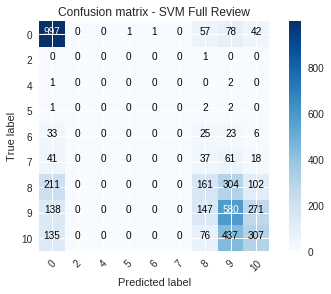

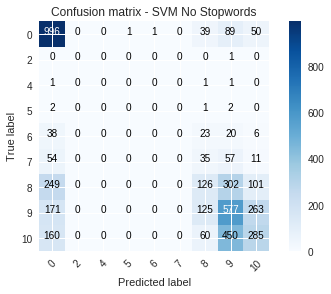

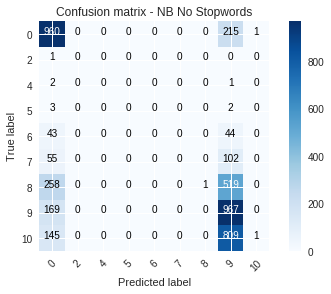

In [12]:
c1 = confusion_matrix(svmy1,svmp1)
c2 = confusion_matrix(svmy2,svmp2)
c3 = confusion_matrix(nby2,nbp2)
class_names = ['0','2', '4', '5', '6', '7', '8', '9', '10']
plt.figure()
plot_confusion_matrix(c1, classes=class_names,normalize=False,title='Confusion matrix - SVM Full Review')
plt.figure()
plot_confusion_matrix(c2, classes=class_names,normalize=False,title='Confusion matrix - SVM No Stopwords')
plt.figure()
plot_confusion_matrix(c3, classes=class_names,normalize=False,title='Confusion matrix - NB No Stopwords')

In [0]:
impact_statement = "Hello world" #@param {type:"string"}